The code was adapted from: https://www.pymc.io/projects/examples/en/latest/case_studies/BART_introduction.html

In [1]:
import warnings

from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pymc_bart as pmb
import bart_rs as pmb

warnings.filterwarnings(action="ignore", category=FutureWarning)

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


In [2]:
import pytensor.tensor as pt
from pytensor.tensor.random.op import RandomVariable

In [2]:
RANDOM_SEED = 8457
rng = np.random.RandomState(RANDOM_SEED)

## Coal mining example

In [3]:
try:
    coal = np.loadtxt(Path("..", "data", "coal.csv"))
except FileNotFoundError:
    coal = np.loadtxt(pm.get_data("coal.csv"))

In [40]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist / 4

In [ ]:
with pm.Model() as model_coal:
    mu_ = pmb.BART("mu_", X=x_data, Y=y_data, m=10, alpha=0.95, beta=2.0)
    # mu = pm.Deterministic("mu", pm.math.exp(mu_))
    # y_pred = pm.Poisson("y_pred", mu=mu, observed=y_data)
    y = pm.Normal("y", mu_, sigma=1., observed=y_data)

    idata_coal = pm.sample(
        tune=300,
        draws=500,
        step=[pmb.PGBART([mu_], num_particles=10)],
        random_seed=42,
        )

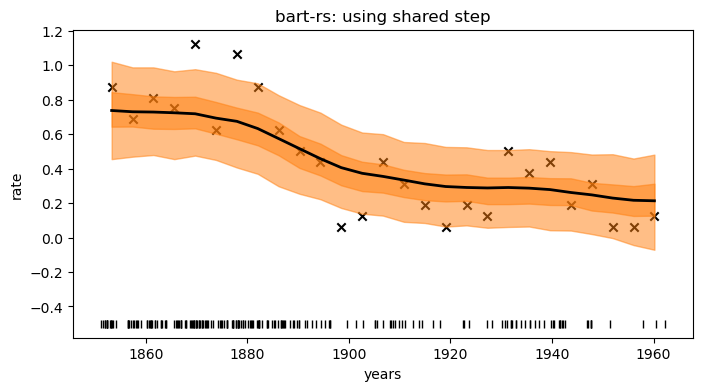

In [43]:
_, ax = plt.subplots(figsize=(8, 4))

rates = idata_coal.posterior["mu_"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.scatter(x_data, y_data / 4, color="black", marker="x")
ax.plot(x_centers, rate_mean, "black", lw=2)
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate")
# plt.ylim((0.0, 6))
plt.title("bart-rs: using shared step");

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/

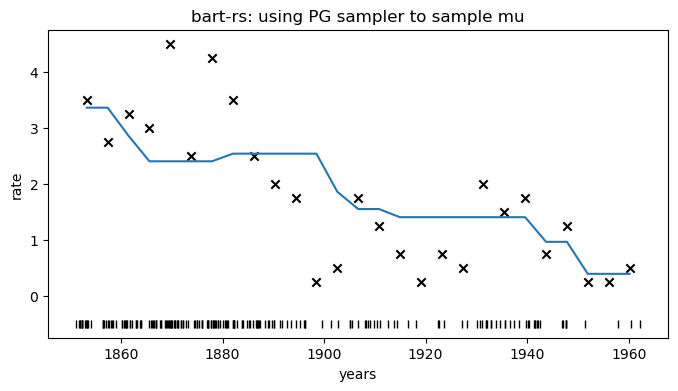

In [38]:
with pm.Model() as model_coal:
    mu_ = pmb.BART("mu_", X=x_data, Y=y_data, m=10, alpha=0.95, beta=2.0)
    y = pm.Normal("y", mu_, sigma=1., observed=y_data)
    step = pmb.PGBART([mu_], num_particles=10)

trees, time = step.astep(1)

_, ax = plt.subplots(figsize=(8, 4))

ax.scatter(x_data, y_data, color="black", marker="x")
ax.plot(x_centers, trees)
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate")
plt.title("bart-rs: using PG sampler to sample mu");

## Bike sharing example

In [45]:
try:
    bikes = pd.read_csv(Path("..", "data", "bikes.csv"))
except FileNotFoundError:
    bikes = pd.read_csv(pm.get_data("bikes.csv"))

X = bikes[["hour", "temperature", "humidity", "workingday"]].values
Y = bikes["count"].values

In [27]:
with pm.Model() as model_bikes:
    alpha = pm.Exponential("alpha", 1)
    mu = pmb.BART("mu", X, np.log(Y))
    y = pm.NegativeBinomial("y", mu=pm.math.exp(mu), alpha=alpha, observed=Y, shape=mu.shape)
    idata_bikes = pm.sample(tune=300, draws=500, compute_convergence_checks=False, random_seed=RANDOM_SEED)
    posterior_predictive_oos_regression_train = pm.sample_posterior_predictive(
        trace=idata_bikes, random_seed=RANDOM_SEED
    )

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

thread '<unnamed>' panicked at /Users/gabestechschulte/Documents/repos/bart-rs/pg-bart/src/pgbart.rs:273:74:
called `Result::unwrap()` on an `Err` value: "Input dimension mismatch"
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
thread '<unnamed>' panicked at /Users/gabestechschulte/Documents/repos/bart-rs/pg-bart/src/pgbart.rs:273:74:
called `Result::unwrap()` on an `Err` value: "Input dimension mismatch"
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


Process worker_chain_0:
Traceback (most recent call last):
Process worker_chain_1:
  File "/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pymc/sampling/parallel.py", line 128, in run
    self._start_loop()
  File "/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pymc/sampling/parallel.py", line 180, in _start_loop
    point, stats = self._step_method.step(self._point)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Traceback (most recent call last):
  File "/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pymc/step_methods/compound.py", line 232, in step
    point, sts = method.step(point)
                 ^^^^^^^^^^^^^^^^^^
  File "/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pymc/step_methods/arraystep.py", line 101, in step
    apoint, stats = self.astep(q)
                    ^^^^^^^^^^^^^
  File "/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12

EOFError: 

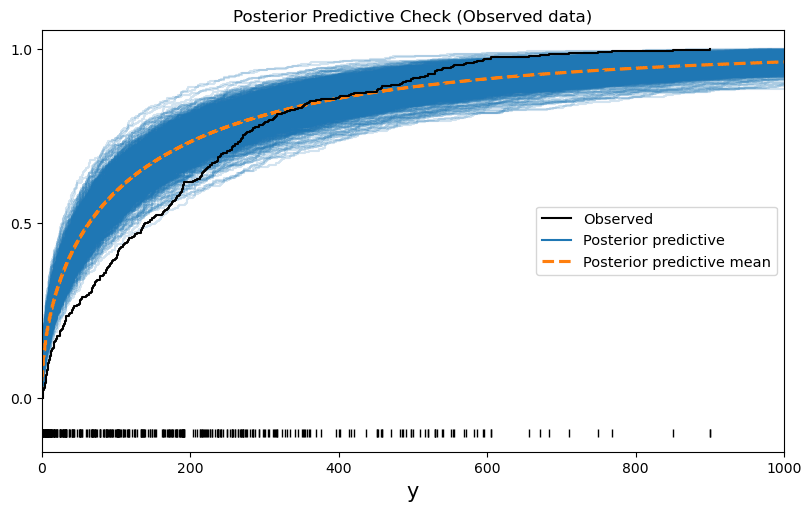

In [26]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(8, 5), sharex=True, sharey=True, layout="constrained"
)
az.plot_ppc(data=posterior_predictive_oos_regression_train, kind="cumulative", observed_rug=True, ax=ax)
ax.set(title="Posterior Predictive Check (Observed data)", xlim=(0, 1_000));

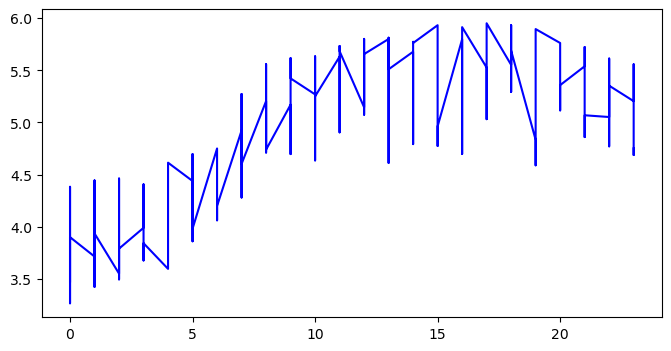

In [25]:
hour = X[:, 0]
num_bikes = Y

mu = idata_bikes["posterior"]["mu"].mean(("chain", "draw")).to_numpy()
std = idata_bikes["posterior"]["mu"].std(("chain", "draw")).to_numpy()

plt.figure(figsize=(8, 4))
# plt.scatter(hour, num_bikes, color="black", marker="x", alpha=0.5)
plt.plot(hour, mu, color="blue");

## Modeling heteroskedasticity with BART

In [5]:
df = pd.read_csv(pm.get_data("marketing.csv"), sep=";", decimal=",")

X = df["youtube"].to_numpy().reshape(-1, 1)
Y = df["sales"].to_numpy()

n_obs = df.shape[0]

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


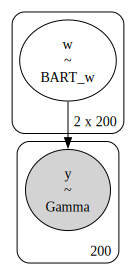

In [6]:
with pm.Model() as model_marketing_full:
    w = pmb.BART("w", X=X, Y=np.log(Y), m=100, shape=(2, n_obs))
    y = pm.Gamma("y", mu=pm.math.exp(w[0]), sigma=pm.math.exp(w[1]), observed=Y)

pm.model_to_graphviz(model=model_marketing_full)

In [7]:
with model_marketing_full:
    idata_marketing_full = pm.sample(2000, random_seed=rng, compute_convergence_checks=False)
    posterior_predictive_marketing_full = pm.sample_posterior_predictive(
        trace=idata_marketing_full, random_seed=rng
    )

/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/gabestechschulte/miniforge3/envs/bart_rs/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(
<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <class 'TypeError'> The type of the replacement (Matrix(float64, shape=(2, 1))) must be compatible with the type of the original Variable (Matrix(float64, shape=(2, 200))). random_make_inplace
ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: random_make_inplace
ERROR (pytensor.graph.rewriting.basic): node: BART_rv{"(i00,i01),(i10),(),(),(),(i50)->(o00)"}(RNG(<Generator(PCG64) at 0x30B611A80>), [2], [[[276.12] ... [278.52]]], [[3.277899 ... 77757626]], [100], [0.95], [2.], [])
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.

KeyboardInterrupt: 